In [1]:
import mido
import numpy as np
import matplotlib.pyplot as plt
import PreProcessor as pp
from keras.models import Model
from tensorflow.keras.layers import Input, SimpleRNN, LSTM, GRU, Dense, Lambda, Softmax, Activation, concatenate
from keras import optimizers
import tensorflow as tf
from utils import *
import gc

In [2]:
dataset = pp.load_dataset("../adl-piano-midi")
ClassicSongs = pp.files_to_songs(dataset["Classical"])
RockSongs = pp.files_to_songs(dataset["Rock"])

channel_to_ind, ind_to_channel, note_to_ind, ind_to_note, velocity_to_ind, ind_to_velocity = pp.dicts_from_songs(ClassicSongs | RockSongs)

time_range = pp.ranges_from_songs(ClassicSongs | RockSongs)

n_Channels = len(channel_to_ind)
n_Notes = len(note_to_ind)
n_Velocities = len(velocity_to_ind)

print("\nNumber of channels   :",n_Channels,"\nNumber of notes      :",n_Notes,"\nNumber of velocities :",n_Velocities,"\nTime range           :",time_range[0],time_range[1])

Couldn't load: ../adl-piano-midi\Classical\Classical\Alexander Borodin\Nocturne.mid
Couldn't load: ../adl-piano-midi\Classical\Classical\Antonio Salieri\Invention.mid
Couldn't load: ../adl-piano-midi\Classical\Classical\Bela Bartok\Andante.mid
Couldn't load: ../adl-piano-midi\Classical\Classical\Bela Bartok\Romanian Folk Dance.mid
Couldn't load: ../adl-piano-midi\Classical\Classical\Claude Debussy\Clair De Lune.mid
Couldn't load: ../adl-piano-midi\Classical\Classical\Franz Schubert\Impromptu in C-Moll.mid
Couldn't load: ../adl-piano-midi\Classical\Classical\Franz Schubert\Impromptu in Ges-dur.mid
Couldn't load: ../adl-piano-midi\Classical\Classical\Franz Schubert\Trois Marches militaires 3.mid
Couldn't load: ../adl-piano-midi\Classical\Classical\Frederic Chopin\Prelude Op 28 No7.mid
Couldn't load: ../adl-piano-midi\Classical\Classical\Giacomo Puccini\O Mio Babibino Caro.mid
Couldn't load: ../adl-piano-midi\Classical\Classical\Jean-Baptiste Lully\Minuet.mid
Couldn't load: ../adl-piano-m

In [3]:
seq_length = 30
val_split = 0.1
test_split = 0.1

CX_Channels, CX_Notes, CX_Velocities, CX_Times, Cy_Channels, Cy_Notes, Cy_Velocities, Cy_Times, Val_CX_Channels, Val_CX_Notes, Val_CX_Velocities, Val_CX_Times, Val_Cy_Channels, Val_Cy_Notes, Val_Cy_Velocities, Val_Cy_Times, Test_CX_Channels, Test_CX_Notes, Test_CX_Velocities, Test_CX_Times, Test_Cy_Channels, Test_Cy_Notes, Test_Cy_Velocities, Test_Cy_Times = pp.prep_data(seq_length,ClassicSongs,n_Channels,n_Notes,n_Velocities,channel_to_ind,note_to_ind,velocity_to_ind,val_split,test_split)
RX_Channels, RX_Notes, RX_Velocities, RX_Times, Ry_Channels, Ry_Notes, Ry_Velocities, Ry_Times, Val_RX_Channels, Val_RX_Notes, Val_RX_Velocities, Val_RX_Times, Val_Ry_Channels, Val_Ry_Notes, Val_Ry_Velocities, Val_Ry_Times, Test_RX_Channels, Test_RX_Notes, Test_RX_Velocities, Test_RX_Times, Test_Ry_Channels, Test_Ry_Notes, Test_Ry_Velocities, Test_Ry_Times = pp.prep_data(seq_length,RockSongs,n_Channels,n_Notes,n_Velocities,channel_to_ind,note_to_ind,velocity_to_ind,val_split,test_split)

print(CX_Channels.shape)
print(RX_Notes.shape)

CX = [CX_Channels, CX_Notes, CX_Velocities, CX_Times]
Cy = [Cy_Channels, Cy_Notes, Cy_Velocities, Cy_Times]
Val_CX = [Val_CX_Channels, Val_CX_Notes, Val_CX_Velocities, Val_CX_Times]
Val_Cy = [Val_Cy_Channels, Val_Cy_Notes, Val_Cy_Velocities, Val_Cy_Times]
Test_CX = [Test_CX_Channels, Test_CX_Notes, Test_CX_Velocities, Test_CX_Times]
Test_Cy = [Test_Cy_Channels, Test_Cy_Notes, Test_Cy_Velocities, Test_Cy_Times]

RX = [RX_Channels, RX_Notes, RX_Velocities, RX_Times]
Ry = [Ry_Channels, Ry_Notes, Ry_Velocities, Ry_Times]
Val_RX = [Val_RX_Channels, Val_RX_Notes, Val_RX_Velocities, Val_RX_Times]
Val_Ry = [Val_Ry_Channels, Val_Ry_Notes, Val_Ry_Velocities, Val_Ry_Times]
Test_RX = [Test_RX_Channels, Test_RX_Notes, Test_RX_Velocities, Test_RX_Times]
Test_Ry = [Test_Ry_Channels, Test_Ry_Notes, Test_Ry_Velocities, Test_Ry_Times]

(56724, 30, 15)
(178048, 30, 126)


In [6]:
dims = [200,200]
n_batch = 200
learning_rate = 0.001

optimizerLSTM = optimizers.Adam(learning_rate=learning_rate)

lossesLSTM = {
    'Channels': 'categorical_crossentropy',
    'Notes': 'categorical_crossentropy',
    'Velocities': 'categorical_crossentropy',
    'Times': 'mean_squared_error'
}


loss_weightsLSTM = {
    'Channels': 0.5,
    'Notes': 5.0,
    'Velocities': 1.0,
    'Times': 1e-6
}

metricsLSTM = {
    'Channels': 'accuracy',
    'Notes': 'accuracy',
    'Velocities': 'accuracy',
    'Times': tol_accuracy
}

LSTM_model = create_model("LSTM",dims,n_Channels,n_Notes,n_Velocities,time_range)
LSTM_model.summary()
LSTM_model.compile(optimizer=optimizerLSTM, loss=lossesLSTM, loss_weights=loss_weightsLSTM, metrics=metricsLSTM)

lossLSTM = []
channels_accuracyLSTM = []
notes_accuracyLSTM = []
velocities_accuracyLSTM = []
times_accuracyLSTM = []

val_lossLSTM = []
val_channels_accuracyLSTM = []
val_notes_accuracyLSTM = []
val_velocities_accuracyLSTM = []
val_times_accuracyLSTM = []

Model: "LSTM_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, None, 15)]   0           []                               
                                                                                                  
 input_6 (InputLayer)           [(None, None, 101)]  0           []                               
                                                                                                  
 input_7 (InputLayer)           [(None, None, 128)]  0           []                               
                                                                                                  
 input_8 (InputLayer)           [(None, None, 1)]    0           []                               
                                                                                         

Epoch 1/10
284/284 [==============================] - 120s 383ms/step - loss: 22.4119 - Channels_loss: 0.7760 - Notes_loss: 3.9002 - Velocities_loss: 2.5213 - Times_loss: 1506.3871 - Channels_accuracy: 0.6998 - Notes_accuracy: 0.0459 - Velocities_accuracy: 0.5711 - Times_tol_accuracy: 3.5211e-06 - val_loss: 21.1644 - val_Channels_loss: 0.6965 - val_Notes_loss: 3.7072 - val_Velocities_loss: 2.2799 - val_Times_loss: 89.7756 - val_Channels_accuracy: 0.6931 - val_Notes_accuracy: 0.0608 - val_Velocities_accuracy: 0.5967 - val_Times_tol_accuracy: 1.3889e-05
Epoch 2/10
284/284 [==============================] - 99s 349ms/step - loss: 20.0436 - Channels_loss: 0.6260 - Notes_loss: 3.4995 - Velocities_loss: 2.2331 - Times_loss: 48.8492 - Channels_accuracy: 0.7191 - Notes_accuracy: 0.0895 - Velocities_accuracy: 0.6031 - Times_tol_accuracy: 3.2277e-05 - val_loss: 19.1644 - val_Channels_loss: 0.6181 - val_Notes_loss: 3.3325 - val_Velocities_loss: 2.1929 - val_Times_loss: 27.9020 - val_Channels_accu

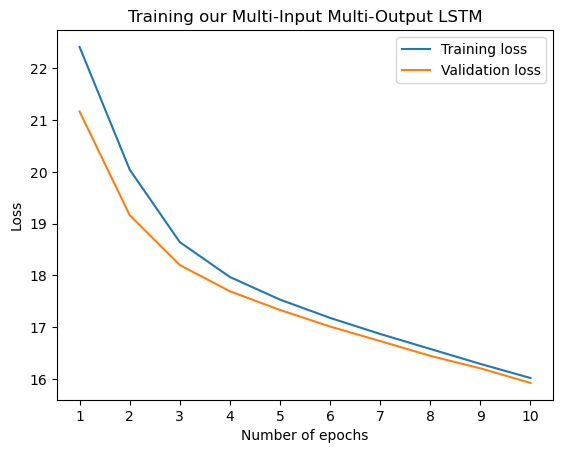

MemoryError: Unable to allocate 2.55 GiB for an array with shape (178048, 30, 128) and data type float32

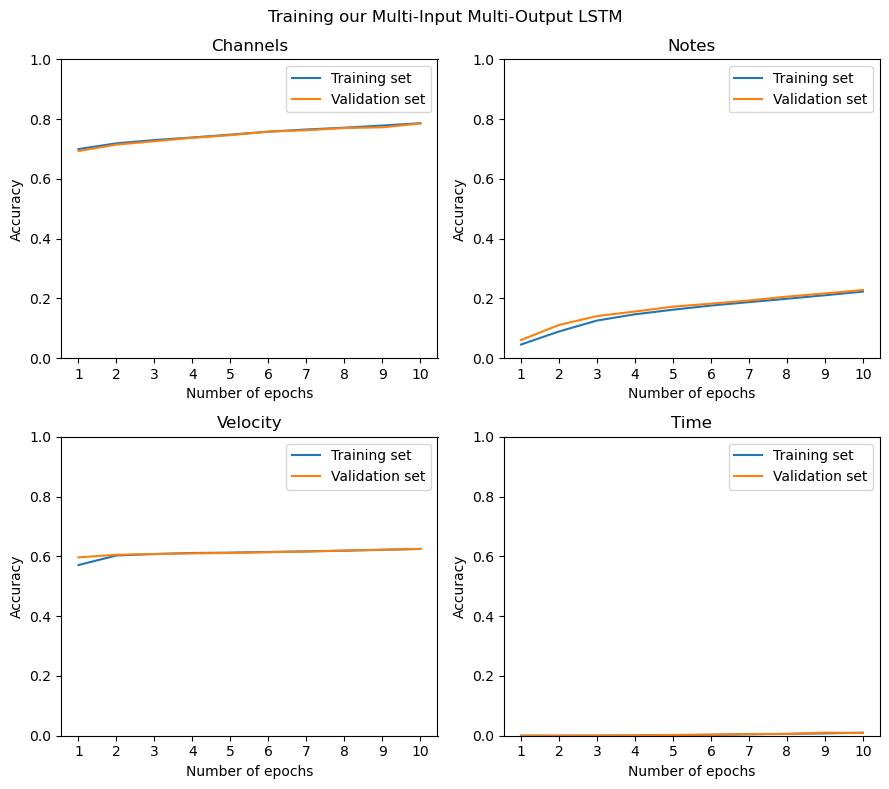

In [7]:
n_epochs = 10

history = LSTM_model.fit(CX, Cy, epochs=n_epochs, batch_size=n_batch, validation_data=(Val_CX,Val_Cy))

lossLSTM += history.history['loss']
channels_accuracyLSTM += history.history['Channels_accuracy']
notes_accuracyLSTM += history.history['Notes_accuracy']
velocities_accuracyLSTM += history.history['Velocities_accuracy']
times_accuracyLSTM += history.history['Times_tol_accuracy']

val_lossLSTM += history.history['val_loss']
val_channels_accuracyLSTM += history.history['val_Channels_accuracy']
val_notes_accuracyLSTM += history.history['val_Notes_accuracy']
val_velocities_accuracyLSTM += history.history['val_Velocities_accuracy']
val_times_accuracyLSTM += history.history['val_Times_tol_accuracy']

plot_training_results("Training our Multi-Input Multi-Output LSTM",lossLSTM,channels_accuracyLSTM,notes_accuracyLSTM,velocities_accuracyLSTM,times_accuracyLSTM,val_lossLSTM,val_channels_accuracyLSTM,val_notes_accuracyLSTM,val_velocities_accuracyLSTM,val_times_accuracyLSTM)

history = LSTM_model.fit(RX, Ry, epochs=n_epochs, batch_size=n_batch, validation_data=(Val_CX,Val_Cy))

lossLSTM += history.history['loss']
channels_accuracyLSTM += history.history['Channels_accuracy']
notes_accuracyLSTM += history.history['Notes_accuracy']
velocities_accuracyLSTM += history.history['Velocities_accuracy']
times_accuracyLSTM += history.history['Times_tol_accuracy']

val_lossLSTM += history.history['val_loss']
val_channels_accuracyLSTM += history.history['val_Channels_accuracy']
val_notes_accuracyLSTM += history.history['val_Notes_accuracy']
val_velocities_accuracyLSTM += history.history['val_Velocities_accuracy']
val_times_accuracyLSTM += history.history['val_Times_tol_accuracy']

plot_training_results("Training our Multi-Input Multi-Output LSTM",lossLSTM,channels_accuracyLSTM,notes_accuracyLSTM,velocities_accuracyLSTM,times_accuracyLSTM,val_lossLSTM,val_channels_accuracyLSTM,val_notes_accuracyLSTM,val_velocities_accuracyLSTM,val_times_accuracyLSTM)

In [ ]:
C_eval = LSTM_model.evaluate(Val_CX,Val_Cy,batch_size=n_batch)
R_eval = LSTM_model.evaluate(Val_RX,Val_Ry,batch_size=n_batch)
print(C_eval)
print(R_eval)

In [10]:
LSTM2_model = create_model("LSTM",dims,n_Channels,n_Notes,n_Velocities,time_range)
LSTM2_model.summary()
LSTM2_model.compile(optimizer=optimizerLSTM, loss=lossesLSTM, loss_weights=loss_weightsLSTM, metrics=metricsLSTM)

lossLSTM2 = []
channels_accuracyLSTM2 = []
notes_accuracyLSTM2 = []
velocities_accuracyLSTM2 = []
times_accuracyLSTM2 = []

val_lossLSTM2 = []
val_channels_accuracyLSTM2 = []
val_notes_accuracyLSTM2 = []
val_velocities_accuracyLSTM2 = []
val_times_accuracyLSTM2 = []

Model: "LSTM_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None, None, 15)]   0           []                               
                                                                                                  
 input_10 (InputLayer)          [(None, None, 101)]  0           []                               
                                                                                                  
 input_11 (InputLayer)          [(None, None, 128)]  0           []                               
                                                                                                  
 input_12 (InputLayer)          [(None, None, 1)]    0           []                               
                                                                                         

In [ ]:
n_epochs = 10

history = LSTM2_model.fit(RX, Ry, epochs=n_epochs, batch_size=n_batch, validation_data=(Val_CX,Val_Cy))

lossLSTM2 += history.history['loss']
channels_accuracyLSTM2 += history.history['Channels_accuracy']
notes_accuracyLSTM2 += history.history['Notes_accuracy']
velocities_accuracyLSTM2 += history.history['Velocities_accuracy']
times_accuracyLSTM2 += history.history['Times_tol_accuracy']

val_lossLSTM2 += history.history['val_loss']
val_channels_accuracyLSTM2 += history.history['val_Channels_accuracy']
val_notes_accuracyLSTM2 += history.history['val_Notes_accuracy']
val_velocities_accuracyLSTM2 += history.history['val_Velocities_accuracy']
val_times_accuracyLSTM2 += history.history['val_Times_tol_accuracy']

#plot_training_results("Training our Multi-Input Multi-Output LSTM2",lossLSTM2,channels_accuracyLSTM2,notes_accuracyLSTM2,velocities_accuracyLSTM2,times_accuracyLSTM2,val_lossLSTM2,val_channels_accuracyLSTM2,val_notes_accuracyLSTM2,val_velocities_accuracyLSTM2,val_times_accuracyLSTM2)

history = LSTM2_model.fit(CX, Cy, epochs=n_epochs, batch_size=n_batch, validation_data=(Val_CX,Val_Cy))

lossLSTM2 += history.history['loss']
channels_accuracyLSTM2 += history.history['Channels_accuracy']
notes_accuracyLSTM2 += history.history['Notes_accuracy']
velocities_accuracyLSTM2 += history.history['Velocities_accuracy']
times_accuracyLSTM2 += history.history['Times_tol_accuracy']

val_lossLSTM2 += history.history['val_loss']
val_channels_accuracyLSTM2 += history.history['val_Channels_accuracy']
val_notes_accuracyLSTM2 += history.history['val_Notes_accuracy']
val_velocities_accuracyLSTM2 += history.history['val_Velocities_accuracy']
val_times_accuracyLSTM2 += history.history['val_Times_tol_accuracy']

plot_training_results("Training our Multi-Input Multi-Output LSTM2",lossLSTM2,channels_accuracyLSTM2,notes_accuracyLSTM2,velocities_accuracyLSTM2,times_accuracyLSTM2,val_lossLSTM2,val_channels_accuracyLSTM2,val_notes_accuracyLSTM2,val_velocities_accuracyLSTM2,val_times_accuracyLSTM2)

Epoch 1/10
197/197 [==============================] - 85s 384ms/step - loss: 20.2582 - Channels_loss: 0.8053 - Notes_loss: 3.3898 - Velocities_loss: 2.9059 - Times_loss: 550.4698 - Channels_accuracy: 0.7446 - Notes_accuracy: 0.1062 - Velocities_accuracy: 0.4943 - Times_tol_accuracy: 0.0016 - val_loss: 20.8880 - val_Channels_loss: 0.4113 - val_Notes_loss: 3.4891 - val_Velocities_loss: 3.2369 - val_Times_loss: 27.4354 - val_Channels_accuracy: 0.8685 - val_Notes_accuracy: 0.1058 - val_Velocities_accuracy: 0.4983 - val_Times_tol_accuracy: 8.7812e-04
Epoch 2/10
197/197 [==============================] - 70s 354ms/step - loss: 16.3108 - Channels_loss: 0.5268 - Notes_loss: 2.6510 - Velocities_loss: 2.7924 - Times_loss: 9.5249 - Channels_accuracy: 0.8138 - Notes_accuracy: 0.2355 - Velocities_accuracy: 0.4969 - Times_tol_accuracy: 0.0041 - val_loss: 20.3023 - val_Channels_loss: 0.3118 - val_Notes_loss: 3.3863 - val_Velocities_loss: 3.2149 - val_Times_loss: 10.2290 - val_Channels_accuracy: 0.886